In [1]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from neural_lam import vis
from IPython.display import display
from ref_info import var_idx
import subprocess

In [2]:
# --- Configurable parameters ---
region = (30, 70, 15, 60)  # (y_start, y_end, x_start, x_end)
# region = (120, 180, 140, 220)  # (y_start, y_end, x_start, x_end)
plot_timestep = 1         # Only plot t=1

# Specify changes for each variable: either "percent" (e.g., 0.1 for +10%) or "fixed" (e.g., 5.0 for +5 units)
var_changes = {
    "pres_0s": {"percent": None, "fixed": None},   # Surface pressure (Pa), typical: [95000, 105000]
    "nlwrs":   {"percent": None, "fixed": None},   # Net longwave radiation at ground (W/m²), typical: [0, 1200]
    "nswrs":   {"percent": None, "fixed": -2},   # Net shortwave radiation at ground (W/m²), typical: [0, 600]
    "rh_s":    {"percent": None, "fixed": +0.05},   # Relative humidity at lowest model level (unitless, [0,1])
    "t_2":     {"percent": None, "fixed": -1},    # Temperature at 2 m above ground (K), typical: [250, 310]
    "t_s":     {"percent": None, "fixed": -0.8},   # Temperature at lowest model level (K), typical: [250, 310]
    "t_850":   {"percent": None, "fixed": -0.4},   # Temperature at 850 hPa (K), typical: [250, 300]
    "t_500":   {"percent": None, "fixed": None},   # Temperature at 500 hPa (K), typical: [220, 280]
}

# Convert variable names to indices for later use
var_change_indices = {var_idx[k]: v for k, v in var_changes.items()}

In [3]:
# --- File paths ---
archive_folder = "data/meps_example_archive/samples/test"
online_folder = "data/meps_online/samples/test"
filename = "nwp_2022090100_mbr000.npy"
archive_path = os.path.join(archive_folder, filename)
online_path = os.path.join(online_folder, filename)

# --- Load data ---
data_ref = np.load(archive_path)
data_edited = data_ref.copy()

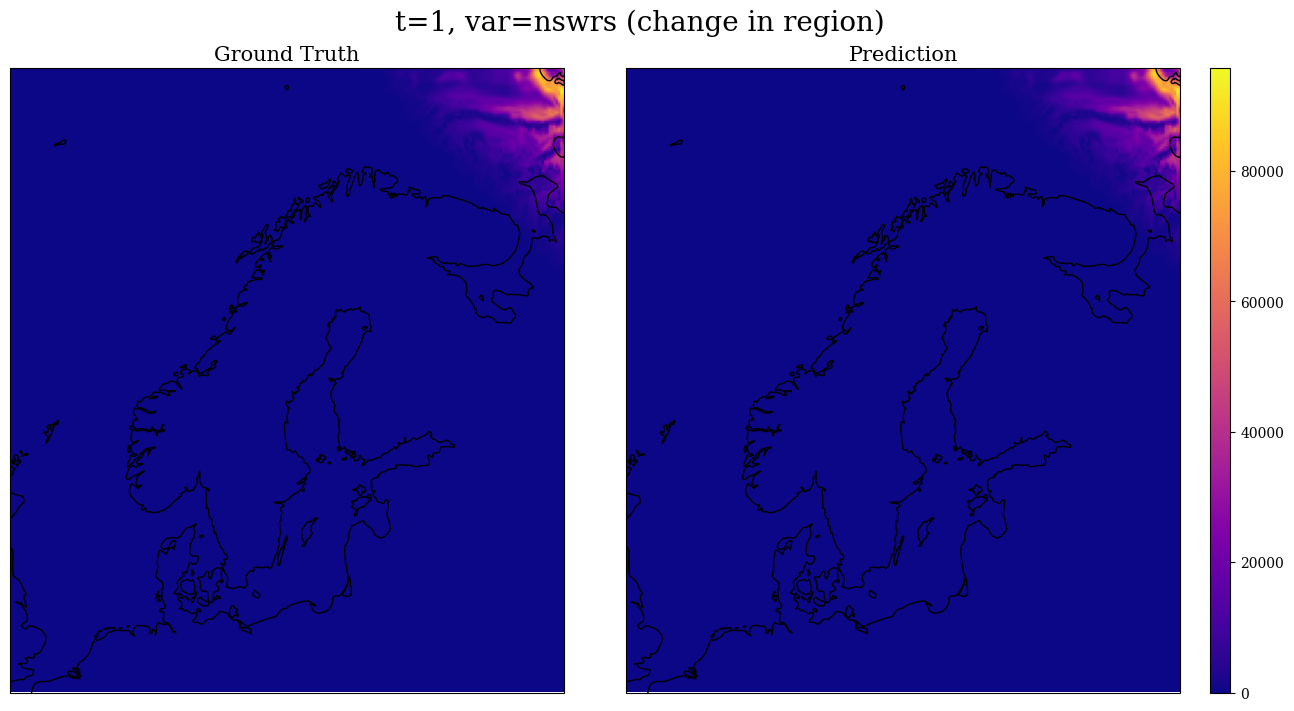

/tmp/ipykernel_73254/2792754654.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


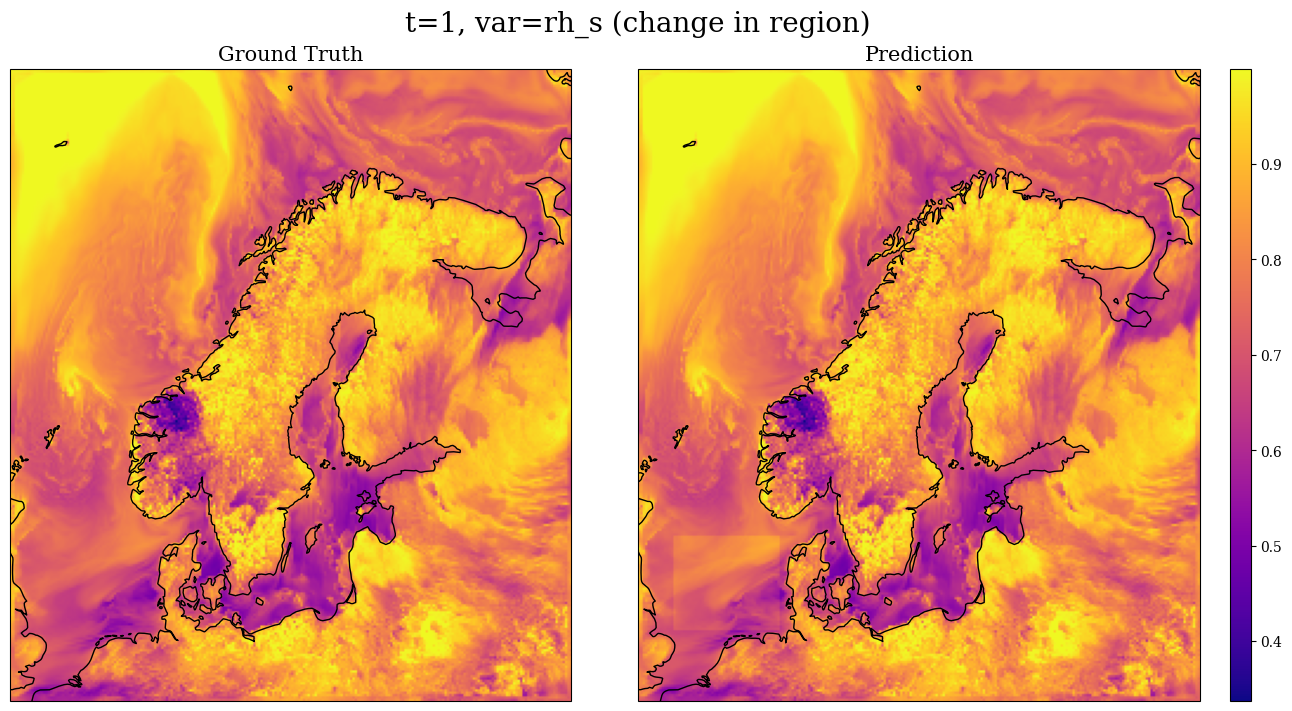

/tmp/ipykernel_73254/2792754654.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


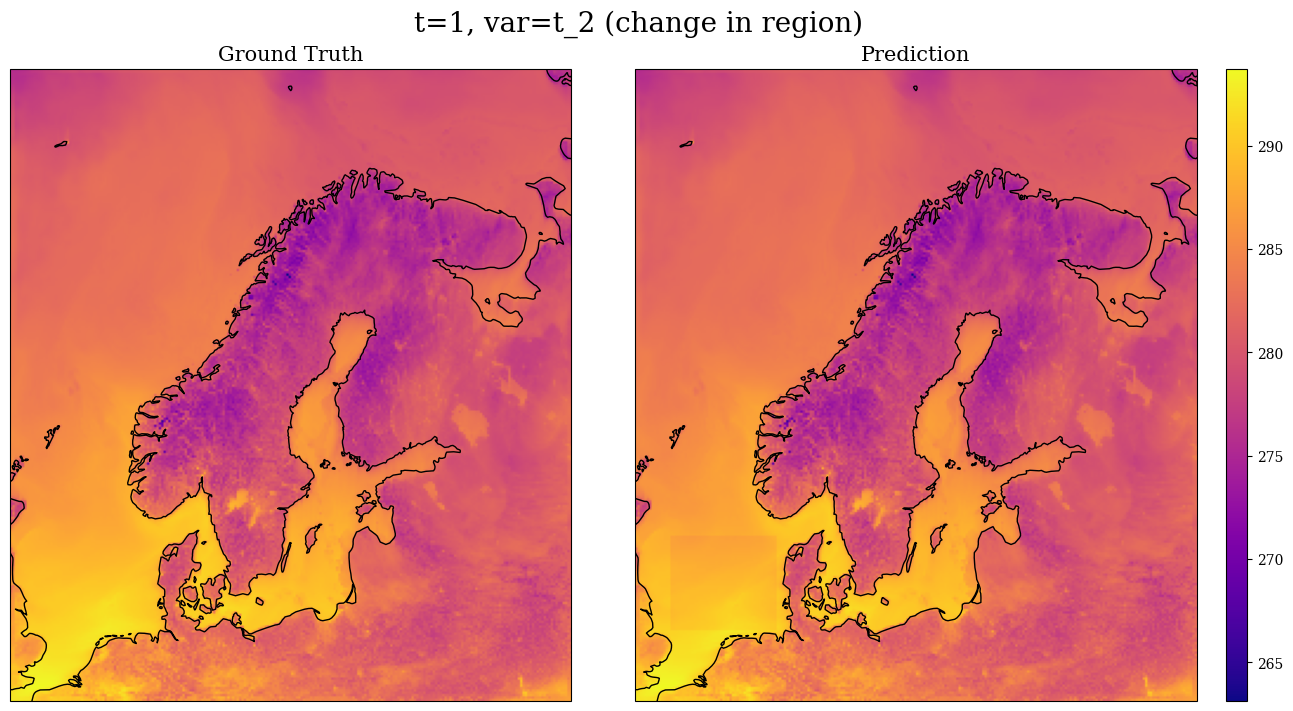

/tmp/ipykernel_73254/2792754654.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


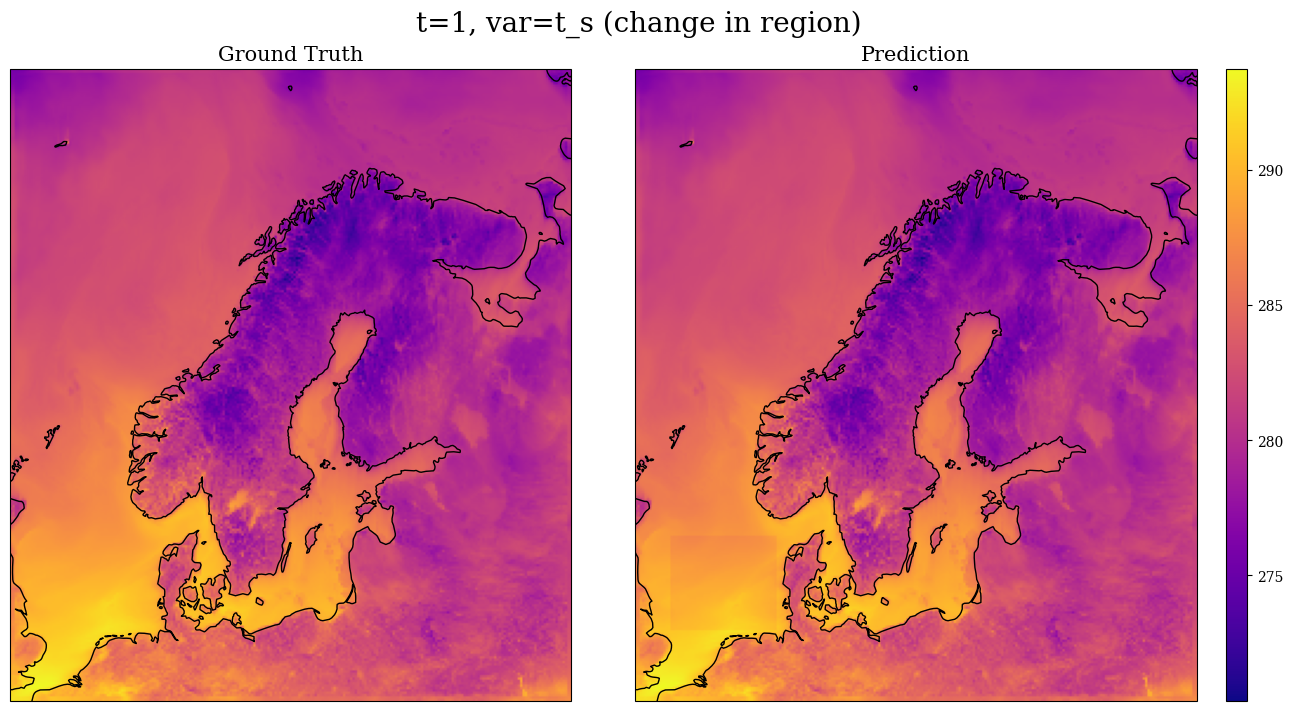

/tmp/ipykernel_73254/2792754654.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


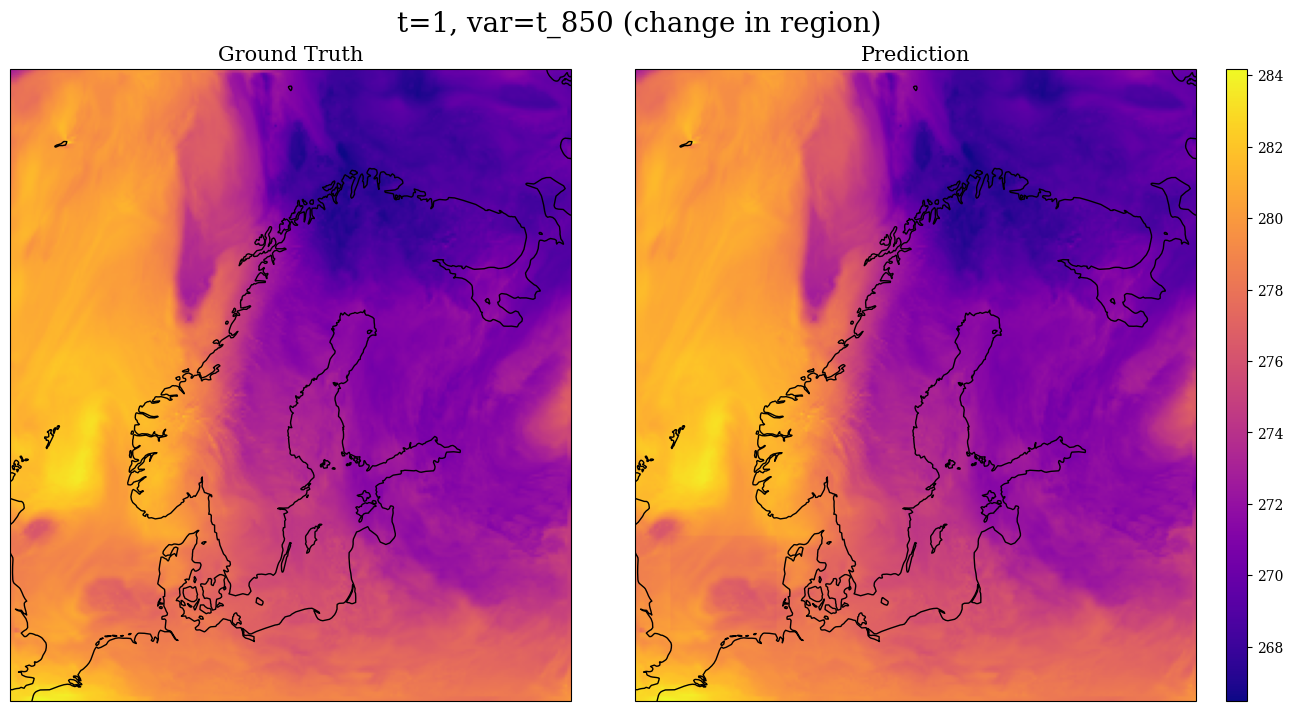

/tmp/ipykernel_73254/2792754654.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [4]:
# --- Apply changes to subregion for t=0 and t=1 ---
y_start, y_end, x_start, x_end = region
for t in [0, 1]:
    for var_name, change in var_changes.items():
        idx = var_idx[var_name]
        grid = data_edited[t, y_start:y_end, x_start:x_end, idx]

        if change["percent"] is not None:
            grid *= (1 + change["percent"])
        if change["fixed"] is not None:
            grid += change["fixed"]

        # Physically sensible clamping
        if var_name.startswith("t_"):  # Temperatures ≥ 220 K
            grid = np.maximum(grid, 220)
        elif var_name == "rh_s":       # RH in [0, 1]
            grid = np.clip(grid, 0, 1)
        elif var_name in {"nswrs", "nlwrs"}:  # Radiation ≥ 0
            grid = np.maximum(grid, 0)

        data_edited[t, y_start:y_end, x_start:x_end, idx] = grid

# --- Save edited file ---
np.save(online_path, data_edited)

# --- Reload edited data for plotting ---
data_edited = np.load(online_path)

# --- Plot full grid for each variable ---
for var_name, change in var_changes.items():
    if change["percent"] is None and change["fixed"] is None:
        continue  # skip unchanged vars

    idx = var_idx[var_name]
    grid_before = data_ref[plot_timestep, :, :, idx]
    grid_after = data_edited[plot_timestep, :, :, idx]

    data_flat_before = grid_before.reshape(-1)
    data_flat_after = grid_after.reshape(-1)
    obs_mask = torch.ones_like(torch.from_numpy(data_flat_before)).float()

    # Use the same color scale for both
    vmin = np.nanmin(data_flat_before)
    vmax = np.nanmax(data_flat_before)

    # Plot with vis.plot_prediction
    vis_fig = vis.plot_prediction(
        torch.from_numpy(data_flat_after),
        torch.from_numpy(data_flat_before),
        obs_mask,
        title=f"t={plot_timestep}, var={var_name} (change in region)",
        vrange=(vmin, vmax)
    )
    display(vis_fig)
    plt.close(vis_fig)

    # Optional: your own side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    im0 = axes[0].imshow(grid_before, origin="lower", cmap="plasma", vmin=vmin, vmax=vmax)
    axes[0].set_title(f"Original t={plot_timestep}, {var_name}")
    im1 = axes[1].imshow(grid_after, origin="lower", cmap="plasma", vmin=vmin, vmax=vmax)
    axes[1].set_title(f"Edited t={plot_timestep}, {var_name}")
    fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.02)
    plt.tight_layout()
    plt.close(fig)